In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV

# 1. Introduction

# 2. Data Import

In [4]:
train_path = "diabetic_data_training.csv"
test_path  = "diabetic_data_test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


# 3. Data Transformation & Exploration

### 3.1 Split data and labels

In [5]:
target_col = "readmitted" 

In [6]:
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

Inspect baseline accuracy for both train and test set.

In [7]:
print(y_test.value_counts(normalize=True))
print(y.value_counts(normalize=True))

readmitted
NO     0.541319
>30    0.349415
<30    0.109266
Name: proportion, dtype: float64
readmitted
NO     0.538875
>30    0.349267
<30    0.111858
Name: proportion, dtype: float64


### 3.2 Train/validation split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 3.3 Split numerical and categorical columns for different imputation method

In [9]:
#detect numerical and categotical columns by data type
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric (auto):", numeric_cols)
print("Categorical (auto):", categorical_cols)

Numeric (auto): ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical (auto): ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [10]:
#manually select categorical columns with int data type
categorical_like_ints = ["admission_type_id", "discharge_disposition_id", "admission_source_id","encounter_id", "patient_nbr",]

for col in categorical_like_ints:
    if col in numeric_cols:
        numeric_cols.remove(col)
        categorical_cols.append(col)

print("Final numeric:", numeric_cols)
print("Final categorical:", categorical_cols)

Final numeric: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Final categorical: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'encounter_id', 'patient_nbr']


# 4. Methodology Overview

We treat the task as a supervised multi-class classification problem with three labels: `<30`, `>30`, and `NO`. 
Given a set of patient attributes \(x\), we aim to learn a discriminative model that maps \(x\) to a predicted 
readmission category \(y\).

### 4.1 Preprocessing pipeline
Rather than hand-crafting different preprocessing steps for each model, we define a single common 
preprocessing pipeline that is reused by all classifiers:

- impute missing numerical values with the median and standardise them,
- impute missing categorical values with the most frequent value,
- one-hot encode categorical features, ignoring unseen categories at test time.

The ColumnTransformer implements 
our feature representation, and the downstream classifiers (logistic regression and MLP) implement different 
discriminative models on top of this representation.

In [11]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# 5. Model Training & Validation

### 5.1 PCA + K-means clustering
Preprocess full training set and get feature matrix.

In [17]:
#preprocess full training set
preprocess_only = preprocess.fit(X)

#get fully numeric matrix ready for PCA
X_processed = preprocess_only.transform(X)

Set up PCA to reduce to two dimension, then fit on processed data.

In [16]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

3-means clustering.

In [20]:
#initialise k-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
#fit on PCA embedding
cluster_labels = kmeans.fit_predict(X_pca)

### 5.2 MLP

The MLP introduces non-linearity through ReLU activations and can capture more complex decision boundaries. 

Simple MLP baseline
- one hidden layer (64 units)
- ReLU activation
- adam optimizer
- L2 penalty

The full model is wrapped in a `Pipeline` so that all steps are applied consistently in every fold.

In [ ]:
#model setup
mlp_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64,),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=80,
        random_state=42
    ))
])

#train model
mlp_clf.fit(X_train, y_train)
y_val_pred_mlp = mlp_clf.predict(X_val)

#performance report
print(classification_report(y_val, y_val_pred_mlp))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred_mlp))

MLP grid search
- MLP model
- GridSearchCV

In [ ]:
#set up MLP model with early stopping (prevents overfitting)
mlp_base = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", MLPClassifier(
        activation="relu",
        solver="adam",
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        max_iter=200,
        random_state=42
    ))
])

#hyperparameters to try
param_grid = {
    "clf__hidden_layer_sizes": [(64,), (128,), (64, 32)],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
    "clf__learning_rate_init": [1e-3, 5e-4]
}

#set up GridSearchCV
mlp_cv = GridSearchCV(
    mlp_base,
    param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

#train model
mlp_cv.fit(X_train, y_train)
print("Best MLP params:", mlp_cv.best_params_)

#performance report
y_val_pred_mlp = mlp_cv.predict(X_val)
print(classification_report(y_val, y_val_pred_mlp))

However, it also has higher capacity and is more prone to overfitting, so we use early stopping and light hyperparameter tuning.

MLP randomized search (more lightweighted)
- MLP model
- RandomizedSearchCV

In [ ]:
#set up MLP model with early stopping
mlp_base_rand = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", MLPClassifier(
        activation="relu",
        solver="adam",
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        max_iter=80,
        random_state=42
    ))
])

#hyperparameter to try
param_dist = {
    "clf__hidden_layer_sizes": [(32,), (64,)],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
    "clf__learning_rate_init": [1e-3, 5e-4],
}

#set up RandomizedSearchCV
mlp_cv_rand = RandomizedSearchCV(
    mlp_base_rand,
    param_distributions=param_dist,
    n_iter=4,
    cv=2,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42
)

#train model
mlp_cv_rand.fit(X_train, y_train)
print("Best params:", mlp_cv_rand.best_params_)

#performance report
y_val_pred_mlp = mlp_cv_rand.predict(X_val)
print(classification_report(y_val, y_val_pred_mlp))

### 5.3 Logistic regression

To compare linear vs nonlinear models we trained logistic regression model that directly estimates class probabilities \(p(y \mid x)\) on top of the one-hot 
feature representation. To handle the imbalanced label distribution (most patients are `NO`, few are `<30`), 
we tune both the regularisation strength and the class weights using cross-validation.

We use a 3-fold cross-validation on the training split and optimise macro-F1, which averages F1 scores over 
the three classes and therefore gives equal weight to the minority `<30` class. 

In [25]:
#set up LR model
base_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        n_jobs=-1
    ))
])

#hyperparameters to try
cw_options = [
    "balanced",
    {"<30": 3.0, ">30": 1.5, "NO": 1.0},
    {"<30": 4.0, ">30": 1.5, "NO": 1.0},
    {"<30": 3.0, ">30": 1.0, "NO": 1.0},
]
param_grid_lr = {
    "clf__C": [0.1, 1.0, 3.0, 10.0],
    "clf__class_weight": cw_options,
}

#set up GridSearchCV
lr_cv = GridSearchCV(
    base_lr,
    param_grid_lr,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

#train model
lr_cv.fit(X_train, y_train)
print("Best params:", lr_cv.best_params_)

#performance report
y_val_pred = lr_cv.predict(X_val)
print(classification_report(y_val, y_val_pred))

Best params: {'clf__C': 0.1, 'clf__class_weight': {'<30': 4.0, '>30': 1.5, 'NO': 1.0}}
              precision    recall  f1-score   support

         <30       0.24      0.26      0.25      2049
         >30       0.48      0.49      0.48      6398
          NO       0.68      0.65      0.66      9871

    accuracy                           0.55     18318
   macro avg       0.46      0.47      0.46     18318
weighted avg       0.56      0.55      0.55     18318



By default, the logistic regression classifier predicts the class with the highest posterior probability. But in our setting the label distribution is strongly imbalanced: the rare `<30` class almost never wins the argmax, so `<30`readmissions are usually under-predicted.

Since the classifier outputs calibrated class probabilities, we can adjust the decision rule without retraining the model. We introduce a per-class threshold tau for `<30`:

- we compute probability for `<30` for each patient;
- if this probability is at least tau, we predict `<30` even if another class has slightly higher probability; otherwise we use the standard argmax rule.

We tune tau on the validation set by scanning values in the range [0.1, 0.9] and selecting the one that maximises macro-F1.

This allows us to trade a small amount of overall accuracy for improved recall and F1 on the minority `<30`
class.

In [40]:
best_lr = lr_cv.best_estimator_
#calculate probability on validation set
probs_val = best_lr.predict_proba(X_val)
#class ordering
classes = best_lr.named_steps["clf"].classes_
idx_30 = list(classes).index("<30")

#when P(<30) >= tau, force prediction to <30
def predict_with_threshold(probs, tau):
    base_pred = probs.argmax(axis=1)
    preds = base_pred.copy()
    mask = probs[:, idx_30] >= tau
    preds[mask] = idx_30
    preds = np.array([classes[i] for i in preds])
    return preds

taus = np.linspace(0.10, 0.90, 500)
tau_results = []
for tau in taus:
    preds = predict_with_threshold(probs_val, tau)
    macro_f1 = f1_score(y_val, [i for i in preds], average="macro")
    tau_results.append((tau, macro_f1))
    print(f"tau={tau:.2f}, macro-F1={macro_f1:.3f}")

#choose best tau
best_tau, best_tau_f1 = max(tau_results, key=lambda x: x[1])
print(f"\nChosen tau for '<30': {best_tau:.2f} (val macro-F1 = {best_tau_f1:.3f})")

tau=0.10, macro-F1=0.129
tau=0.10, macro-F1=0.131
tau=0.10, macro-F1=0.134
tau=0.10, macro-F1=0.136
tau=0.11, macro-F1=0.139
tau=0.11, macro-F1=0.141
tau=0.11, macro-F1=0.144
tau=0.11, macro-F1=0.146
tau=0.11, macro-F1=0.149
tau=0.11, macro-F1=0.151
tau=0.12, macro-F1=0.154
tau=0.12, macro-F1=0.157
tau=0.12, macro-F1=0.160
tau=0.12, macro-F1=0.163
tau=0.12, macro-F1=0.165
tau=0.12, macro-F1=0.168
tau=0.13, macro-F1=0.171
tau=0.13, macro-F1=0.175
tau=0.13, macro-F1=0.179
tau=0.13, macro-F1=0.183
tau=0.13, macro-F1=0.186
tau=0.13, macro-F1=0.190
tau=0.14, macro-F1=0.193
tau=0.14, macro-F1=0.196
tau=0.14, macro-F1=0.199
tau=0.14, macro-F1=0.203
tau=0.14, macro-F1=0.207
tau=0.14, macro-F1=0.211
tau=0.14, macro-F1=0.215
tau=0.15, macro-F1=0.218
tau=0.15, macro-F1=0.221
tau=0.15, macro-F1=0.225
tau=0.15, macro-F1=0.229
tau=0.15, macro-F1=0.232
tau=0.15, macro-F1=0.235
tau=0.16, macro-F1=0.238
tau=0.16, macro-F1=0.242
tau=0.16, macro-F1=0.245
tau=0.16, macro-F1=0.248
tau=0.16, macro-F1=0.252


# 6. Results

### 6.1 PCA + K-means result

Color by true labels.

In [ ]:
classes = y.unique()
colors = {cls: i for i, cls in enumerate(classes)}
cvals = [colors[cls] for cls in y]

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cvals, alpha=0.3, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Patients (coloured by readmission)")
plt.show()

Plot clustering result.

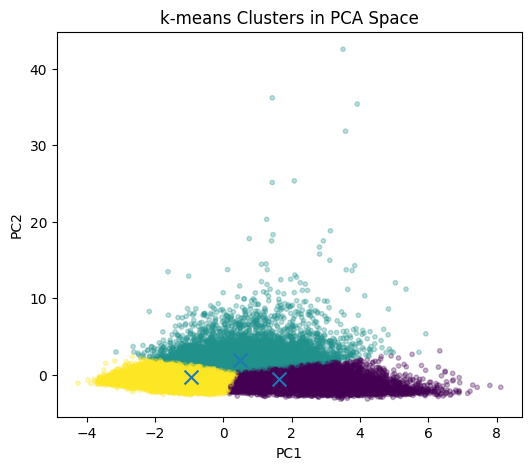

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, alpha=0.3, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker="x", s=100)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("k-means Clusters in PCA Space")
plt.show()

The PCA projection shows a largely continuous cloud of points, and the k-means clusters overlap heavily in the PCA space, indicating each cluster contains a mix of `<30`, `>30`, and `NO` cases. This suggests that the dataset does not naturally decompose into well separated patient clusters, and supports our decision to rely on supervised discriminative models rather than unsupervised clustering for the main prediction task.

### 6.2 MLP results

We adopt the best hyperparameters and evaluate it on the 
same test set. This allows us to directly compare the linear and non-linear discriminative models under the same evaluation protocol.

Simple MLP

In [ ]:
#evaluate on test set
y_test_pred_mlp = mlp_clf.predict(X_test)

print("=== Simple MLP ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_mlp))
print("Test macro-F1:", f1_score(y_test, y_test_pred_mlp, average="macro"))
print(classification_report(y_test, y_test_pred_mlp))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_mlp))

MLP Grid Search CV

In [ ]:
#adopt the best hyperparameters
best_mlp_cv = mlp_cv.best_estimator_

#evaluate on test set
y_test_pred_mlp = best_mlp_cv.predict(X_test)

print("=== MLP Grid Search CV ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_mlp))
print("Test macro-F1:", f1_score(y_test, y_test_pred_mlp, average="macro"))
print(classification_report(y_test, y_test_pred_mlp))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_mlp))

MLP Randomized Seach CV

In [ ]:
#adopt the best hyperparameters
best_mlp_cv_rand = mlp_cv_rand.best_estimator_

#evaluate on test set
y_test_pred_mlp = best_mlp_cv_rand.predict(X_test)

print("=== MLP Randomized Search CV ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_mlp))
print("Test macro-F1:", f1_score(y_test, y_test_pred_mlp, average="macro"))
print(classification_report(y_test, y_test_pred_mlp))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_mlp))

### 6.3 Logistic Regression results

Using the best hyperparameters from Section 5.3, we evaluate it once on the test set. This provides our final estimate of generalisation performance.

In [41]:
#adopt the best hyperparameters
best_lr = lr_cv.best_estimator_
#evaluate on test set
y_test_pred_lr = best_lr.predict(X_test)

print("Test acc:", accuracy_score(y_test, y_test_pred_lr))
print("Test macro-F1:", f1_score(y_test, y_test_pred_lr, average="macro"))
print(classification_report(y_test, y_test_pred_lr))
print("confusion_matrix:\n", confusion_matrix(y_test, y_test_pred_lr))

Test acc: 0.5501621302937998
Test macro-F1: 0.4646729378241316
              precision    recall  f1-score   support

         <30       0.24      0.26      0.25      1112
         >30       0.47      0.50      0.48      3556
          NO       0.68      0.64      0.66      5509

    accuracy                           0.55     10177
   macro avg       0.46      0.47      0.46     10177
weighted avg       0.56      0.55      0.55     10177

confusion_matrix:
 [[ 291  438  383]
 [ 487 1765 1304]
 [ 444 1522 3543]]


In [42]:
# Thresholded predictions with tau tuned on validation set
probs_test = best_lr.predict_proba(X_test)
y_test_pred_tau = predict_with_threshold(probs_test,best_tau)

print("\n=== Logistic Regression (thresholded for '<30'): test performance ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_tau))
print("Macro-F1:", f1_score(y_test, y_test_pred_tau, average="macro"))
print(classification_report(y_test, y_test_pred_tau))
print(confusion_matrix(y_test, y_test_pred_tau))


=== Logistic Regression (thresholded for '<30'): test performance ===
Accuracy: 0.5482951753954997
Macro-F1: 0.4637918313571479
              precision    recall  f1-score   support

         <30       0.24      0.27      0.25      1112
         >30       0.47      0.49      0.48      3556
          NO       0.68      0.64      0.66      5509

    accuracy                           0.55     10177
   macro avg       0.46      0.47      0.46     10177
weighted avg       0.56      0.55      0.55     10177

[[ 298  431  383]
 [ 512 1740 1304]
 [ 450 1517 3542]]


The thresholded decision rule for `<30` slightly increased recall for the minority class on the test set
(from 0.26 to 0.27) but also slightly reduced precision, leaving the F1 score for `<30` essentially unchanged
(0.25 vs 0.25). At the same time, performance on the `>30` and `NO` classes decreased slightly, so both
overall accuracy (0.550 → 0.548) and macro-F1 (0.4647 → 0.4638) decreased.

This illustrates that the value of tau which maximised macro-F1 on the validation set does not necessarily
transfer to the test set: tuning tau is effectively another hyperparameter choice, and it can overfit
to the validation split. Since the thresholded rule does not offer a consistent improvement, we retain the
standard argmax decision rule for our final logistic regression model, and treat tau-tuning as an exploratory
experiment.

### 6.4 Best Model results

Select best model and refit on the full training data (train + validation set combined), and evaluate it on the test set.

In [ ]:
#adopt the best hyperparameters
best_model = best_lr

#refit on full training data
best_model.fit(X,y)

#evaluate on test set
y_test_pred = best_model.predict(X_test)

print("Test acc:", accuracy_score(y_test, y_test_pred))
print("Test macro-F1:", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))
print("confusion_matrix:\n", confusion_matrix(y_test, y_test_pred))

# 7. Final Predictions on Test Set

Finally, we demonstrate how the trained model can be used to generate predictions for new patients. Because our logistic regression model is wrapped in a single scikit-learn `Pipeline` (preprocessing + classifier), we can pass in raw feature columns and obtain class labels in one step. The following code illustrates how to produce and save predictions for a generic new dataset with the same schema as the training data.

In [ ]:
#could be adjusted to new patient data
new_df = X_test.copy()

#generate predictions
new_preds = best_model.predict(new_df)

output = pd.DataFrame({
    "encounter_id": new_df["encounter_id"],
    "readmitted_pred": new_preds,
})

output.head()

#save to csv
output.to_csv("final_predictions_lr.csv", index=False)